In [1]:
import numpy as np
import yfinance as yf
from coskweness_cokurtosis import coskewness, cokurtosis
from portfolio_hubo_qaoa import HigherOrderPortfolioQAOA
import random
random.seed(1)

n_stocks = 2
stocks = ["AAPL", "GOOGL", "MSFT", "AMZN", "META", "TSLA", "WMT", "CAT", "KO", "IBM", "INTC", "CSCO", "ORCL", "QCOM", 
          "NVDA", "ADBE", "PYPL", "CRM", "ACN", "TXN", "AVGO", "INTU", "AMAT", "MU"]
stocks = random.sample(stocks, n_stocks)

data = yf.download(stocks, start="2015-01-01", end="2021-01-01")
returns = data["Close"].pct_change().dropna()
stocks = returns.columns

numpy_returns = returns.to_numpy()
expected_returns = numpy_returns.mean(axis=0)*252
print(returns.mean())
print(expected_returns)
covariance_matrix = np.cov(numpy_returns, rowvar=False)*252
coskewness_tensor = coskewness(numpy_returns)*(252**2)
cokurtosis_tensor = cokurtosis(numpy_returns)*(252**3)

budget = 4

portfolio_hubo = HigherOrderPortfolioQAOA(stocks=stocks,
                                          expected_returns=expected_returns, 
                                          covariance_matrix=covariance_matrix,
                                          budget=budget,
                                          coskewness_tensor=coskewness_tensor, 
                                          cokurtosis_tensor=cokurtosis_tensor,
                                          log_encoding = True, 
                                          layers = 5)

hubo_bin_simple = portfolio_hubo.get_cost_hubo_bin_simplified()

#print(hubo_bin_simple)

smallest_eigenvalues, smallest_eigenvectors, smallest_bitstrings, first_excited_energy, first_excited_state, optimized_portfolio, second_optimized_portfolio = portfolio_hubo.solve_exactly()

[*********************100%***********************]  2 of 2 completed


Ticker
ACN     0.000905
META    0.001029
dtype: float64
[0.2279947  0.25932474]
Number of qubits per asset:  3
Constructing cost hubo with integer variables
Optimized Weights (considering variance and returns):
0: 62.43%
1: 37.57%
Maximized utility from classical mean variance:  0.15524320208485207
Adding budget constraints to the cost function -> constructing full hubo problem
Replacing integer variables with binary variables
Simplifying the binary cost function
Converting binary cost function to Ising Hamiltonian
Constructing QAOA circuits


In [2]:
print(smallest_eigenvalues)
print(smallest_bitstrings)
print(first_excited_energy)
print("Best: ", optimized_portfolio)
print("Second best: ", second_optimized_portfolio)

[tensor(-15.6227666, requires_grad=True)]
[[1, 1, 0, 1, 0, 0]]
-15.52943514767556
Best:  [{'ACN': 3, 'META': 1}]
Second best:  [{'ACN': 2, 'META': 2}]


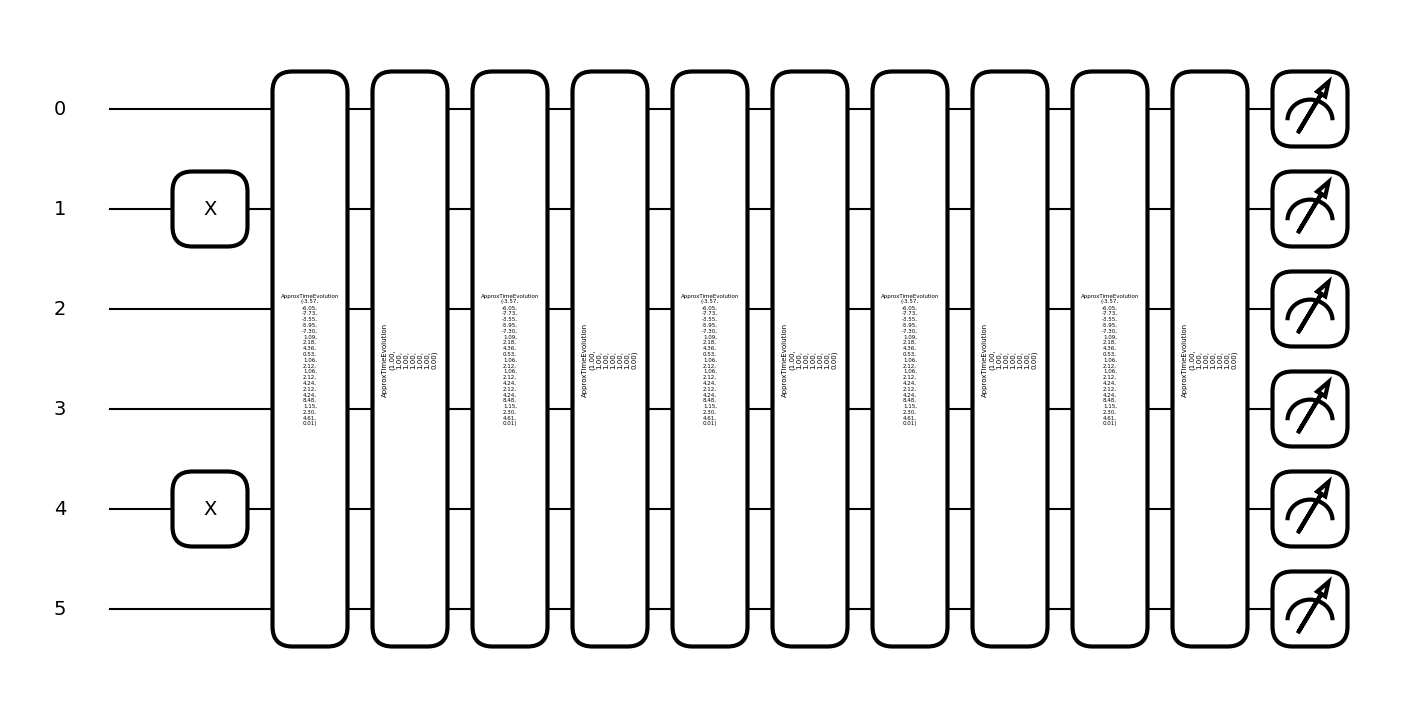

In [3]:
portfolio_hubo.draw_qaoa_circuit()

In [ ]:
two_most_probable_states, smallest_eigenvalue, params, total_steps, states_probs, optimized_portfolios = portfolio_hubo.solve_with_iterative_QAOA(max_layers=5)

Trying with 1 layers
Two most probable states: ['100001', '100000'] with probabilities [np.float64(0.015624999999999962), np.float64(0.015624999999999967)]
Final expectation value: -15.529435147675539
Optimized portfolios: [{'ACN': 1, 'META': 4}, {'ACN': 1, 'META': 0}]
Trying with 2 layers


In [ ]:
print(two_most_probable_states)
print(smallest_eigenvalue)
print(params)
print(total_steps)
print(states_probs)
print(optimized_portfolios)

['010000', '100010']
-673.9857776475602
[[ 4.64108357e-03 -7.91676528e-01]
 [-6.57623317e-18  1.57079633e+00]]
1000
[np.float64(0.01562499999999994), np.float64(0.015624999999999943)]
[{'ACN': 2, 'META': 0}, {'ACN': 1, 'META': 2}]


In [ ]:
from pypfopt import EfficientFrontier

risk_aversion = 3
ef = EfficientFrontier(returns.mean(), covariance_matrix)
weights = ef.max_quadratic_utility(risk_aversion=risk_aversion)

print("Optimized Weights (considering variance and returns):")
for asset, weight in weights.items():
    print(f"{asset}: {weight:.2%} which is {budget*weight:.2} stocks")

Optimized Weights (considering variance and returns):
ACN: 56.05% which is 2.2 stocks
META: 43.95% which is 1.8 stocks
